In [209]:
%load_ext autoreload
%autoreload 2

#standard imports
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("..")

#rl book imports
import rl
from rl.markov_decision_process import MarkovDecisionProcess
from rl.markov_process import State, MarkovProcess, NonTerminal, Terminal

from typing import (Callable, Dict, Generic, Iterator, Iterable, List,
                    Mapping, Optional, Sequence, Tuple, TypeVar, overload)


from rl.distribution import Categorical, Distribution, Constant, Choose
from rl.policy import Policy
from rl.monte_carlo import epsilon_greedy_policy, greedy_policy_from_qvf, glie_mc_control, mc_prediction
from rl.function_approx import LinearFunctionApprox, AdamGradient
from rl.td import glie_sarsa, q_learning
from rl.td_lambda import td_lambda_prediction


#custom imports 
import utils as u
import data as dat
import mdp_agent as ag
import baseline_policies as bp
import q_plots as qp
import backtest as btest
import v_predictor as v_true
import v_convergence as v_conv 
import v_plots2 as v2
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [210]:
GAMMA = 0.8

# Data

In [211]:
with open("FX_Residuals/residuals_PCA_3F_6_2.pkl","rb") as f:
    fx_data = pickle.load(f)

In [452]:
data = (1+fx_data[["HUF"]]).cumprod()

In [453]:
u.plot_plotly(data)

In [454]:
split = "2017-01-01"
build_data = dat.Train_Test_Builder(data,60,split,half_life=700)

In [455]:
build_data.build_train_test(N=30,length_episode=300)
train,test = build_data.train, build_data.test

In [456]:
test.iloc[59]

HUF    1.020508
Name: 2017-01-10 00:00:00, dtype: float64

In [457]:
u.plot_plotly_multiple(train)
u.plot_plotly(test)

# Prediction

In [458]:
trader = ag.Trading(train,test,lookback=60)
mrp_buy = trader.apply_policy(bp.BuyAndHold())

In [459]:
trader.generate_start_state("test",start="2017-01-01").sample()

NonTerminal(state={'Spot': 1.0206076427584425, 'position': 0, 'date': Timestamp('2017-01-03 00:00:00'), 'data':                  HUF
date                
2016-10-11  1.014065
2016-10-13  1.015812
2016-10-14  1.017242
2016-10-17  1.018357
2016-10-18  1.019418
...              ...
2023-12-11  1.061494
2023-12-12  1.060688
2023-12-13  1.057525
2023-12-14  1.058213
2023-12-15  1.059519

[1753 rows x 1 columns], 'lookback': 60, 'time index': 0, 'ts_features':                  HUF      mu_t   sigma_t    S_down      S_up   z_score  \
date                                                                     
2016-10-11  1.014065  1.014065       NaN       NaN       NaN       NaN   
2016-10-13  1.015812  1.014083  0.001235  1.012230  1.015935  1.400142   
2016-10-14  1.017242  1.014114  0.001812  1.011397  1.016832  1.726294   
2016-10-17  1.018357  1.014157  0.002291  1.010720  1.017593  1.833449   
2016-10-18  1.019418  1.014209  0.002739  1.010101  1.018317  1.902055   
...              ...   

In [460]:
def intercept(x):
    return 1

def z_score_state(x):
    return (x.state["Spot"] - x.state["mu_t"])/(x.state["sigma_t"])

def trend_mu(x):
    return (x.state["trend"])

def ar1(x):
    return (x.state["ar1"])


adam_g = AdamGradient(
        learning_rate=0.0001,
        decay1=0.9,
        decay2=0.999
    )    

v_approx = LinearFunctionApprox.create(feature_functions=[intercept,z_score_state,trend_mu,ar1],adam_gradient=adam_g,direct_solve=False)



initial_state = trader.generate_start_state("train")
traces = mrp_buy.reward_traces(initial_state)


vfs_td_lambda = td_lambda_prediction(
        traces,
        v_approx,
        GAMMA,
        0.5
)

In [461]:
td_l = v_conv.V_Convergence_Analyzer(vfs_td_lambda,trader)
td_l.get_v(1000,freqSSE=1)

In [462]:
history = [u.get_list_states(trader,"test")]

In [463]:
V_analyze = v2.V_Analyzer_Mehdi(td_l.v,history,range_plot=4)

x_range, t_range, f_values = V_analyze.generate_V_heatmap()

V_analyze.plot_heatmap(list(x_range),t_range,f_values)

In [464]:
data.index[-1]

Timestamp('2023-12-15 00:00:00')

In [483]:
class RollingMeanRevPrediction():

    def __init__(self,data,lookback, length_epsiode, num_iter,refit_freq, min_obs = 300):
        self.data = data
        self.length_epsiode = length_epsiode
        self.refit_freq = refit_freq
        self.lookback = lookback
        self.num_iter = num_iter
        self.signals = []
        self.next_split = "1800-01-01"
        self.min_obs  = min_obs

        self.prediction = None


    def fit_rolling(self):
        split  = self.data.index[self.min_obs]
        end_of_data = False
        while not end_of_data:
            end_of_data = self.fit(split)
            split = self.next_split
        
        self.prediction = pd.concat(self.signals)


    def fit(self,split):
        """
        Generates signal for a single OOS period of size self.refit_freq
        """
        
        build_data = dat.Train_Test_Builder(self.data,self.lookback,split)
        build_data.build_train_test(N=30,length_episode=300)
        train,test = build_data.train, build_data.test

        trader = ag.Trading(train, test, self.lookback)
        mrp_buy = trader.apply_policy(bp.BuyAndHold())

        def intercept(x):
            return 1

        def z_score_state(x):
            return (x.state["Spot"] - x.state["mu_t"])/(x.state["sigma_t"])

        def trend_mu(x):
            return (x.state["trend"])

        def ar1(x):
            return (x.state["ar1"])

        adam_g = AdamGradient(
                learning_rate=0.0001,
                decay1=0.9,
                decay2=0.999
            )    

        v_approx = LinearFunctionApprox.create(feature_functions=[intercept,z_score_state,trend_mu,ar1],
                                                adam_gradient=adam_g,
                                                direct_solve=False)

        initial_state = trader.generate_start_state("train")
        traces = mrp_buy.reward_traces(initial_state)
        vfs_td_lambda = td_lambda_prediction(
                traces,
                v_approx,
                GAMMA,
                0.5
        )
        td_l = v_conv.V_Convergence_Analyzer(vfs_td_lambda,trader)

        td_l.get_v(self.num_iter)

        signal = {}

        for i_,state in enumerate(u.get_list_states(trader,"test",start=split)):
            if i_+1 >= self.refit_freq:
                self.next_split = state.state["date"]
                break   
            else:
                signal[state.state["date"]] = td_l.v(state)
        new_signal = pd.DataFrame.from_dict(signal, orient='index', columns=['signal'])
        end_of_data = len(new_signal)+1<self.refit_freq
        self.signals.append(new_signal)

        return end_of_data        

In [484]:
roll = RollingMeanRevPrediction(data,
                                lookback = 60,
                                length_epsiode = 300,
                                num_iter = 1000,
                                refit_freq = 100,
                                min_obs = 400)

In [485]:
roll.fit_rolling()

preds = roll.prediction

In [486]:
def quick_backtest(price_df, prediction_df):
    # Ensure there's only one column in each dataframe and get their names
    price_col = price_df.columns[0]
    prediction_col = prediction_df.columns[0]
    
    # Merge dataframes on index
    merged_df = prediction_df.join(price_df, how='left')
    
    # Calculate returns for the merged timestamps
    merged_df['next_price'] = merged_df[price_col].shift(-1)
    merged_df['return'] = 10*merged_df[prediction_col] * (merged_df['next_price'] - merged_df[price_col]) / merged_df[price_col]
    return merged_df.dropna(subset=['return'])[['return']]

rets = quick_backtest(data,preds)

In [488]:
def compute_positive_ratio(df, column_name):
    """
    Computes the ratio of the number of positive entries to the sum of positive and negative entries in a DataFrame column.

    Parameters:
    - df: The DataFrame containing the data.
    - column_name: The name of the column to perform the calculation on.

    Returns:
    - The computed ratio.
    """
    num_entries_gt_0 = (df[column_name] > 0).sum()
    num_entries_lt_0 = (df[column_name] < 0).sum()

    # Ensure the denominator is not zero to avoid division by zero error
    if num_entries_gt_0 + num_entries_lt_0 > 0:
        ratio = num_entries_gt_0 / (num_entries_gt_0 + num_entries_lt_0)
        return ratio
    else:
        return None

compute_positive_ratio(rets,"return")

0.5011990407673861

In [491]:
np.sqrt(252)*rets.mean()/rets.std()

return    0.452113
dtype: float64

<AxesSubplot:>

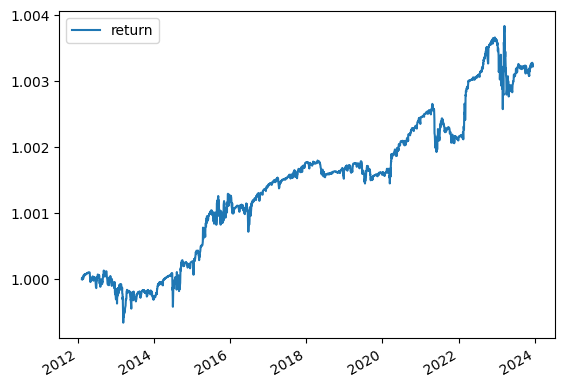

In [487]:
(1+rets).cumprod().plot()

In [428]:
gbp_rets  = rets

In [447]:
zar_rets = rets

In [470]:
huf_rets = rets

In [482]:
u.plot_plotly((zar_rets+gbp_rets+huf_rets).cumsum())